In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.special as sp_spec
import pandas as pd
np.random.seed(3)

# ***Assignment 1.3 - CAVI***
Consider the model defined by Equation (10.21)-(10-23) in Bishop, for which DGM is presented below:

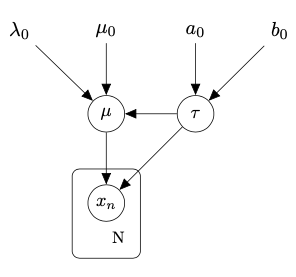

### ***Question 1.3.12:***

Implement a function that generates data points for the given model.

In [ ]:
def generate_data(mu, tau, N):
  # Insert your code here
    D = np.random.normal(mu, np.sqrt(1/tau), N)
    return D


Set μ = 1, τ = 0.5 and generate datasets with size N=10,100,1000. Plot the histogram for each of 3
datasets you generated.



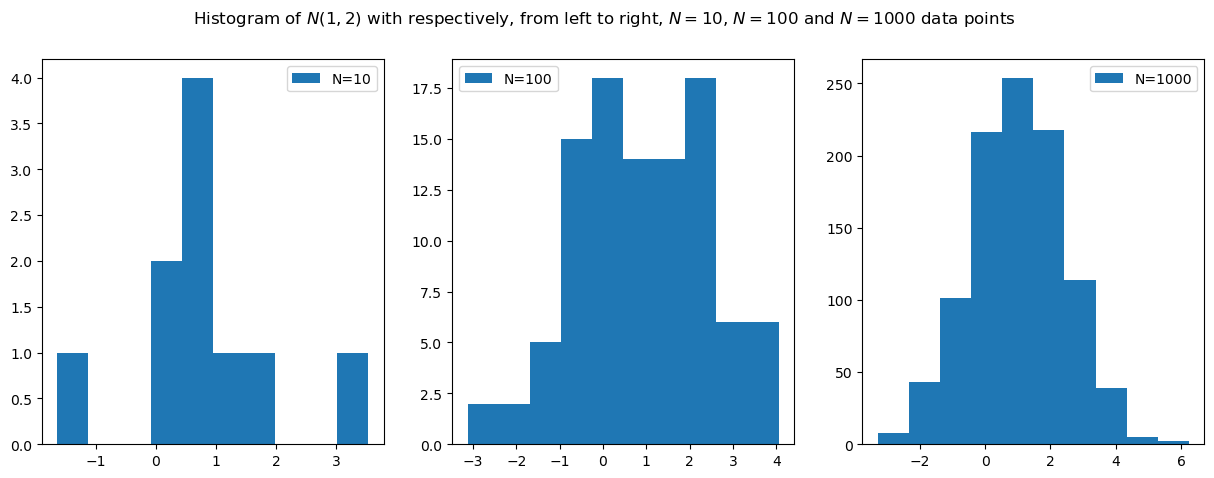

In [ ]:
mu = 1
tau = 0.5

dataset_1 = generate_data(mu, tau, 10)
dataset_2 = generate_data(mu, tau, 100)
dataset_3 = generate_data(mu, tau, 1000)

# Visulaize the datasets via histograms
# Insert your code here
list_dataset = [dataset_1, dataset_2, dataset_3]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for i in range(len(list_dataset)):
    dataset = list_dataset[i]
    axes[i].hist(dataset, label=f'N={len(dataset)}')
#     sns.histplot(dataset, label=f'N={len(dataset)}', ax=axes[i])
    axes[i].legend()
plt.suptitle(r'Histogram of $N(1, 2)$ with respectively, from left to right, $N=10$, $N=100$ and $N=1000$ data points')
# plt.savefig('histogram.png')
plt.show()

### ***Question 1.3.13:***

Find ML estimates of the variables μ and τ

In [ ]:
def ML_est(data):
  # insert your code
    mu_ml = np.mean(data)
    tau_ml = 1/np.var(data, ddof=0)
    return mu_ml, tau_ml

In [ ]:
print('For N=10, the Maximum Likelihood estimates for the parameters mu and tau are respectively', np.round(ML_est(dataset_1),2))
print('For N=100, the Maximum Likelihood estimates for the parameters mu and tau are respectively', np.round(ML_est(dataset_2),2))
print('For N=1000, the Maximum Likelihood estimates for the parameters mu and tau are respectively', np.round(ML_est(dataset_3),2))

For N=10, the Maximum Likelihood estimates for the parameters mu and tau are respectively [0.8  0.67]
For N=100, the Maximum Likelihood estimates for the parameters mu and tau are respectively [0.88 0.45]
For N=1000, the Maximum Likelihood estimates for the parameters mu and tau are respectively [1.03 0.49]


We observe that the more data we have, the closer the parameters are to the true values: [1.00, 0.50].

### ***Question 1.3.14:***
You will implement the VI algorithm for the variational distribution in Equation (10.24) in Bishop. Start with introducing the prior parameters:

In [ ]:
# prior parameters
mu_0 = 1
lambda_0 = 0.5
a_0 = 2
b_0 = 1

Continue with a helper function that computes ELBO:


In [ ]:
def compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N):
    # given the prior and posterior parameters together with the data,
    # compute ELBO here
    N = len(D)
#     eps = 0.0001
    E_log_tau = sp_spec.digamma(a_N) - np.log(b_N)
    CR_likelihood = -N/2*np.log(2*np.pi) + N/2*E_log_tau - 0.5*(a_N/b_N)*np.sum(D**2 + 1/lambda_N + mu_N**2 - 2*D*mu_N)
    CR_mu = 0.5*np.log(lambda_0/(2*np.pi)) + 0.5*E_log_tau - lambda_0/2*(a_N/b_N)*(1/lambda_N + mu_N**2 + mu_0**2 - 2*mu_0*mu_N)
    CR_tau = (a_0 - 1)*E_log_tau + a_0*np.log(b_0) - b_0*(a_N/b_N) - np.log(sp_spec.gamma(a_0))
    H_mu = 0.5*np.log(2*np.pi/lambda_N) + 0.5
    H_tau = a_N - np.log(b_N) + sp_spec.gammaln(a_N) + (1 - a_N)*sp_spec.digamma(a_N)
    elbo = CR_likelihood + CR_mu + CR_tau + H_mu + H_tau
    return elbo

Now, implement the CAVI algorithm:

In [ ]:
def update_q_mu(D, mu_0, lambda_0, a_N, b_N):
    N = len(D)
    mu_N = (lambda_0*mu_0 + np.sum(D)) / (lambda_0 + N)
    lambda_N = (lambda_0 + N) * (a_N / b_N)
    return mu_N, lambda_N

In [ ]:
def update_q_tau(D, a_0, b_0, mu_0, lambda_0, mu_N, lambda_N):
    N = len(D)
    a_N = a_0 + (N+1)/2
    b_N = b_0 + 0.5*(np.sum(D**2) + lambda_0*(mu_0)**2 - 2*(np.sum(D) + lambda_0*mu_0)*mu_N + (lambda_0 + N)*(1/lambda_N + mu_N**2))
    return a_N, b_N

In [ ]:
def CAVI(D, a_0, b_0, mu_0, lambda_0, n_iter):
    # make an initial guess for the expected value of tau
#     initial_guess_exp_tau = 5
    a_N = 20
    b_N = 10

    # CAVI iterations ...
    # save ELBO for each iteration, plot them afterwards to show convergence
    elbos = np.zeros(n_iter)
    for i in range(0, n_iter):
        mu_N, lambda_N = update_q_mu(D, mu_0, lambda_0, a_N, b_N)
        a_N, b_N = update_q_tau(D, a_0, b_0, mu_0, lambda_0, mu_N, lambda_N)
        elbos[i] = compute_elbo(D, a_0, b_0, mu_0, lambda_0, a_N , b_N, mu_N, lambda_N)
    
    return a_N, b_N, mu_N, lambda_N, elbos

### ***Question 1.3.15:***

What is the exact posterior? First derive it in closed form, and then implement a function that computes it for the given parameters:


In [ ]:
def compute_exact_posterior(D, a_0, b_0, mu_0, lambda_0):
    # your implementation
    N = len(D)
    mu_0_star = (np.sum(D)+lambda_0*mu_0)/(lambda_0+N)
    lambda_0_star = lambda_0 + N
    a_0_star = a_0 + N/2
    b_0_star = b_0 + np.sum(D**2)/2 + lambda_0*(mu_0**2)/2 - 0.5*((np.sum(D) + lambda_0*mu_0)**2)/(lambda_0 + N)
    
    return mu_0_star, lambda_0_star, a_0_star, b_0_star

### ***Question 1.3.16:***
Run the VI algorithm on the datasets. Compare the inferred variational
distribution with the exact posterior and the ML estimate. Visualize the results and discuss your
findings.



In [ ]:
def log_pdf_exact_post(mu, tau, mu_0_star, lambda_0_star, a_0_star, b_0_star):
    return a_0_star * np.log(b_0_star) - sp_spec.gammaln(a_0_star) + 0.5 * np.log(lambda_0_star / (2 * np.pi)) + (a_0_star - 1/2) * np.log(tau) - b_0_star * tau - 0.5 * lambda_0_star * tau * (mu - mu_0_star)**2

def log_pdf_approx_post(mu, tau, mu_N, lambda_N, a_N, b_N):
    return a_N * np.log(b_N) - sp_spec.gammaln(a_N) + 0.5 * np.log(lambda_N / (2 * np.pi)) + (a_N - 1) * np.log(tau) - b_N * tau - 0.5 * lambda_N * (mu - mu_N)**2

**First dataset**

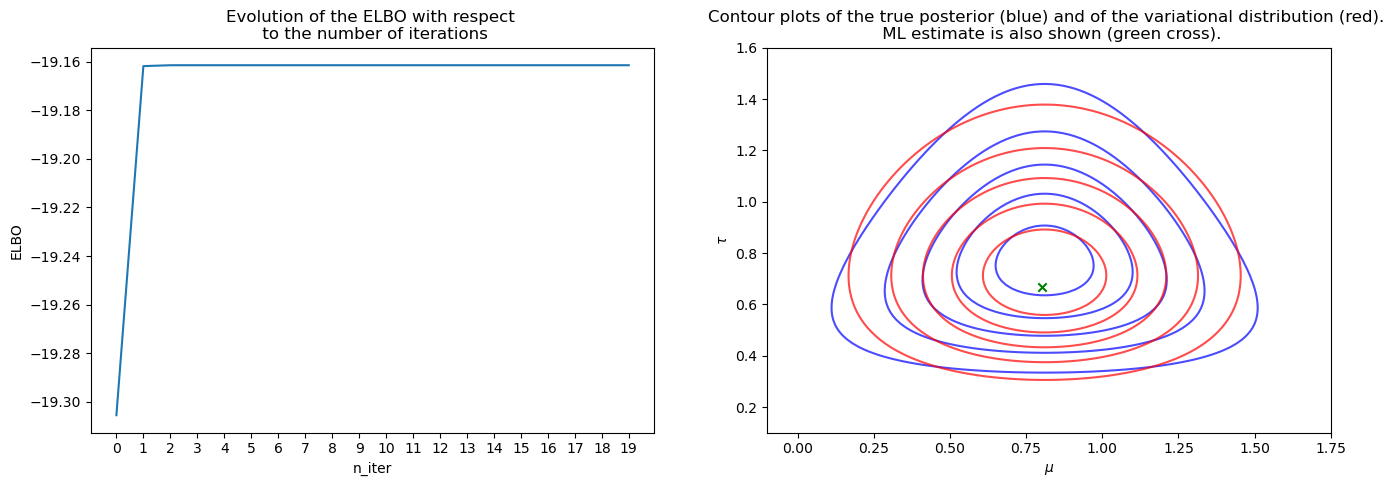

In [ ]:
dataset = dataset_1
n_iter = 20

# ML estimates, VI estimates, true parameters
mu_ml, tau_ml = ML_est(dataset)
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset, a_0, b_0, mu_0, lambda_0, n_iter)
mu_0_star, lambda_0_star, a_0_star, b_0_star = compute_exact_posterior(dataset, a_0, b_0, mu_0, lambda_0)

# plot elbos, show convergence
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].plot(elbos)
ax[0].set_title('Evolution of the ELBO with respect \n to the number of iterations')
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('n_iter')
ax[0].set_xticks(np.arange(0,n_iter))

#  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot
# definition of the grid
mu = np.linspace(-0.1, 1.75, 100)
tau = np.linspace(0.1, 1.6, 100)
muv, tauv = np.meshgrid(mu, tau)

# compute exact posterior and approx posterior on the grid defined above
lg_pdf_ex_post = log_pdf_exact_post(muv, tauv, mu_0_star, lambda_0_star, a_0_star, b_0_star)
pdf_ex_post = np.exp(lg_pdf_ex_post - sp_spec.logsumexp(lg_pdf_ex_post))

lg_pdf_aprx_post = log_pdf_approx_post(muv, tauv, mu_N, lambda_N, a_N, b_N)
pdf_aprx_post = np.exp(lg_pdf_aprx_post - sp_spec.logsumexp(lg_pdf_aprx_post))

# graph contour
levels = 5
ax[1].contour(muv, tauv, pdf_ex_post, colors='blue', levels=levels, alpha=0.7)
ax[1].contour(muv, tauv, pdf_aprx_post, colors='red', levels=levels, alpha=0.7)
ax[1].scatter(mu_ml, tau_ml, color='green', label='ML Estimates', marker='x')
ax[1].set_title('Contour plots of the true posterior (blue) and of the variational distribution (red). \n ML estimate is also shown (green cross).')
ax[1].set_xlabel(r'$\mu$')
ax[1].set_ylabel(r'$\tau$')
# ax.set_title('Contours des Distributions Réelle et Approximative')
# plt.savefig('ELBO_and_Contour_dataset_1.png')
plt.show()

**Second dataset**

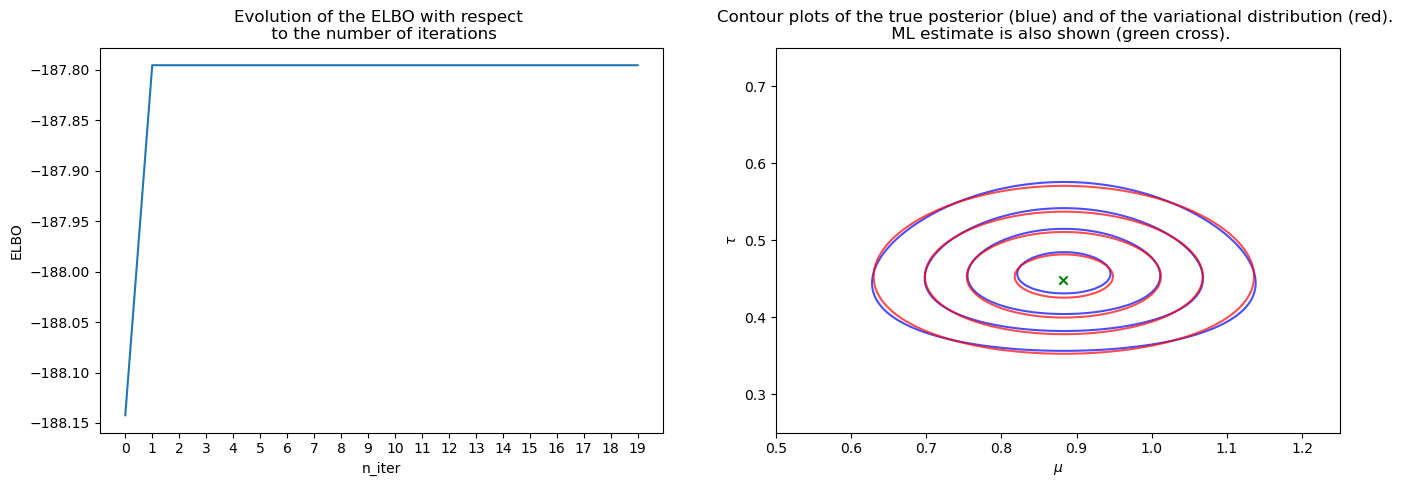

In [ ]:
dataset = dataset_2
n_iter = 20

# ML estimates, VI estimates, true parameters
mu_ml, tau_ml = ML_est(dataset)
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset, a_0, b_0, mu_0, lambda_0, n_iter)
mu_0_star, lambda_0_star, a_0_star, b_0_star = compute_exact_posterior(dataset, a_0, b_0, mu_0, lambda_0)

# plot elbos, show convergence
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].plot(elbos)
ax[0].set_title('Evolution of the ELBO with respect \n to the number of iterations')
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('n_iter')
ax[0].set_xticks(np.arange(0,n_iter))

#  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot
# definition of the grid
mu = np.linspace(0.5, 1.25, 100)
tau = np.linspace(0.25, 0.75, 100)
muv, tauv = np.meshgrid(mu, tau)

# compute exact posterior and approx posterior on the grid defined above
lg_pdf_ex_post = log_pdf_exact_post(muv, tauv, mu_0_star, lambda_0_star, a_0_star, b_0_star)
pdf_ex_post = np.exp(lg_pdf_ex_post - sp_spec.logsumexp(lg_pdf_ex_post))

lg_pdf_aprx_post = log_pdf_approx_post(muv, tauv, mu_N, lambda_N, a_N, b_N)
pdf_aprx_post = np.exp(lg_pdf_aprx_post - sp_spec.logsumexp(lg_pdf_aprx_post))

# graph contour
levels = 5
ax[1].contour(muv, tauv, pdf_ex_post, colors='blue', levels=levels, alpha=0.7)
ax[1].contour(muv, tauv, pdf_aprx_post, colors='red', levels=levels, alpha=0.7)
ax[1].scatter(mu_ml, tau_ml, color='green', label='ML Estimates', marker='x')
ax[1].set_title('Contour plots of the true posterior (blue) and of the variational distribution (red). \n ML estimate is also shown (green cross).')
ax[1].set_xlabel(r'$\mu$')
ax[1].set_ylabel(r'$\tau$')
# ax.set_title('Contours des Distributions Réelle et Approximative')
# plt.savefig('ELBO_and_Contour_dataset_2.png')
plt.show()

**Third dataset**

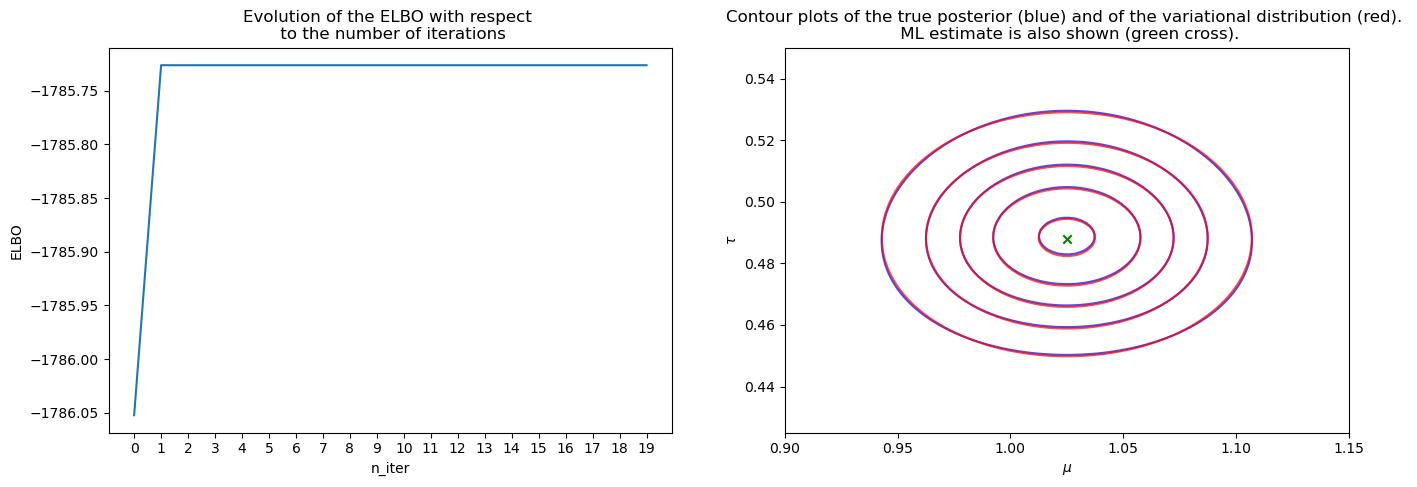

In [ ]:
dataset = dataset_3
n_iter = 20

# ML estimates, VI estimates, true parameters
mu_ml, tau_ml = ML_est(dataset)
a_N, b_N, mu_N, lambda_N, elbos = CAVI(dataset, a_0, b_0, mu_0, lambda_0, n_iter)
mu_0_star, lambda_0_star, a_0_star, b_0_star = compute_exact_posterior(dataset, a_0, b_0, mu_0, lambda_0)

# plot elbos, show convergence
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax[0].plot(elbos)
ax[0].set_title('Evolution of the ELBO with respect \n to the number of iterations')
ax[0].set_ylabel('ELBO')
ax[0].set_xlabel('n_iter')
ax[0].set_xticks(np.arange(0,n_iter))

#  compare exact_post_dist with the CAVI result ( = q(a_N, b_N, mu_N, lambda_N) ) using for ex. contour plots, show also ML estimate on this plot
# definition of the grid
mu = np.linspace(0.9, 1.15, 100)
tau = np.linspace(0.425, 0.550, 100)
muv, tauv = np.meshgrid(mu, tau)

# compute exact posterior and approx posterior on the grid defined above
lg_pdf_ex_post = log_pdf_exact_post(muv, tauv, mu_0_star, lambda_0_star, a_0_star, b_0_star)
pdf_ex_post = np.exp(lg_pdf_ex_post - sp_spec.logsumexp(lg_pdf_ex_post))

lg_pdf_aprx_post = log_pdf_approx_post(muv, tauv, mu_N, lambda_N, a_N, b_N)
pdf_aprx_post = np.exp(lg_pdf_aprx_post - sp_spec.logsumexp(lg_pdf_aprx_post))

# graph contour
levels = 5
ax[1].contour(muv, tauv, pdf_ex_post, colors='blue', levels=levels, alpha=0.7)
ax[1].contour(muv, tauv, pdf_aprx_post, colors='red', levels=levels, alpha=0.7)
ax[1].scatter(mu_ml, tau_ml, color='green', label='ML Estimates', marker='x')
ax[1].set_title('Contour plots of the true posterior (blue) and of the variational distribution (red). \n ML estimate is also shown (green cross).')
ax[1].set_xlabel(r'$\mu$')
ax[1].set_ylabel(r'$\tau$')
# ax.set_title('Contours des Distributions Réelle et Approximative')
# plt.savefig('ELBO_and_Contour_dataset_3.png')
plt.show()